In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import cv2

In [2]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_ffdfc1b455fc4520816d984a902d9c9b = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='Z2avhu3RCEizwloRJAOAGNgvKgxMRHkpOf5idccqXXe0',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

streaming_body_3 = client_ffdfc1b455fc4520816d984a902d9c9b.get_object(Bucket='braintumordetection-donotdelete-pr-xxtjthtcdcmap6', Key='brain tumor dataset.zip')['Body']

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/

In [3]:
from io import BytesIO
import zipfile
unzip=zipfile.ZipFile(BytesIO(streaming_body_3.read()),'r')
file_paths=unzip.namelist()
for path in file_paths:
    unzip.extract(path)

In [4]:
pwd

'/home/wsuser/work'

In [5]:
filenames = os.listdir('/home/wsuser/work/brain_tumor_dataset/yes')

In [6]:
data = '/home/wsuser/work/brain_tumor_dataset/'
No_brain_tumor = '/home/wsuser/work/brain_tumor_dataset/no/'
Yes_brain_tumor = '/home/wsuser/work/brain_tumor_dataset/yes/'

In [7]:
dirlist=[No_brain_tumor, Yes_brain_tumor]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  253    labels:  253


In [8]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(253,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,/home/wsuser/work/brain_tumor_dataset/no/no 92...,No
1,/home/wsuser/work/brain_tumor_dataset/no/27 no...,No
2,/home/wsuser/work/brain_tumor_dataset/no/6 no.jpg,No
3,/home/wsuser/work/brain_tumor_dataset/no/No18.jpg,No
4,/home/wsuser/work/brain_tumor_dataset/no/no 10...,No


In [9]:
print(df['labels'].value_counts())

Yes    155
No      98
Name: labels, dtype: int64


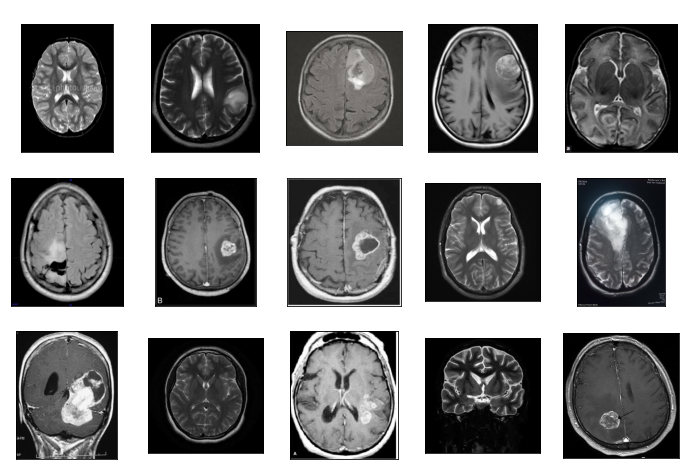

In [10]:
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (216, 2)
test set shape: (13, 2)
validation set shape: (24, 2)


In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [13]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (224,224), batch_size = 32, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(224,224), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 216 validated image filenames belonging to 2 classes.
Found 24 validated image filenames belonging to 2 classes.
Found 13 validated image filenames belonging to 2 classes.


In [14]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [15]:
from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights="imagenet", 
    input_shape=(224, 224, 3),
    include_top=False,
)
base_model.trainable = False
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable

In [16]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)
]


model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 50, callbacks = [callbacks], verbose = 1)

Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 0.7583 - accuracy: 0.5463

/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


7/7 [==============================] - 28s 3s/step - loss: 0.7583 - accuracy: 0.5463 - val_loss: 0.9394 - val_accuracy: 0.4167
Epoch 2/50
7/7 [==============================] - 22s 3s/step - loss: 0.7402 - accuracy: 0.5278 - val_loss: 0.9153 - val_accuracy: 0.5000
Epoch 3/50
7/7 [==============================] - 22s 3s/step - loss: 0.7303 - accuracy: 0.5787 - val_loss: 0.8747 - val_accuracy: 0.3750
Epoch 4/50
7/7 [==============================] - 22s 3s/step - loss: 0.7493 - accuracy: 0.5509 - val_loss: 0.8494 - val_accuracy: 0.3750
Epoch 5/50
7/7 [==============================] - 22s 3s/step - loss: 0.6743 - accuracy: 0.6019 - val_loss: 0.8525 - val_accuracy: 0.4167
Epoch 6/50
7/7 [==============================] - 22s 3s/step - loss: 0.7093 - accuracy: 0.5648 - val_loss: 0.7978 - val_accuracy: 0.5000
Epoch 7/50
7/7 [==============================] - 22s 3s/step - loss: 0.6930 - accuracy: 0.5972 - val_loss: 0.8811 - val_accuracy: 0.4583
Epoch 8/50
7/7 [=============================

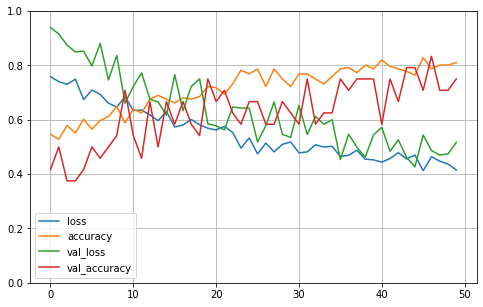

In [17]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [19]:
model.save('Tumor_classifier_model.h5')

In [20]:
!tar -zcvf image-classification-model.tgz Tumor_classifier_model.h5

Tumor_classifier_model.h5


In [21]:
ls -1

brain_tumor_dataset/
image-classification-model.tgz
no/
Tumor_classifier_model.h5
tumor.h5
yes/


In [22]:
!pip install watson-machine-learning-client --upgrade

     |████████████████████████████████| 538 kB 16.9 MB/s eta 0:00:01


In [23]:
from ibm_watson_machine_learning import APIClient
wml_credentials = {
    "url":"https://us-south.ml.cloud.ibm.com",
    "apikey":"5GQQhTeup9tsoiaZdE5g5yAQ1t_hFNYkHuE_wjmd6w10"
}
client = APIClient(wml_credentials)

In [25]:
client = APIClient(wml_credentials)

In [26]:
def guid_from_space_name(client, space_name):
    space = client.spaces.get_details()
    return(next(item for item in space['resources'] if item['entity']["name"] == space_name)['metadata']['id'])

In [28]:
space_uid = guid_from_space_name(client,'Brain tomor detection')
print("Space UID = "+space_uid)

Space UID = b03c9359-d7c4-470c-8115-d8769a032f56


In [29]:
client.set.default_space(space_uid)

'SUCCESS'

In [30]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12      020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9      0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
runtime-22.1-py3.9             12b83a1

In [34]:
software_spec_uid = client.software_specifications.get_uid_by_name("runtime-22.1-py3.9")
software_spec_uid

'12b83a17-24d8-5082-900f-0ab31fbfd3cb'

In [35]:
model_details = client.repository.store_model(model='image-classification-model.tgz',meta_props={
    client.repository.ModelMetaNames.NAME:"CNN",
    client.repository.ModelMetaNames.TYPE:"tensorflow_2.7",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_spec_uid
}
                                             )
model_id=client.repository.get_model_uid(model_details)

This method is deprecated, please use get_model_id()


/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/ibm_watson_machine_learning/repository.py:1452: UserWarning: This method is deprecated, please use get_model_id()
  warn("This method is deprecated, please use get_model_id()")


In [36]:
model_id

'166df482-4ea2-4c66-9015-0178365a47f4'

In [ ]:
client.repository.download(model_id,'my_model.tar.gz')